<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/train_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning recognizer with keras-ocr

This is an interactive example of the code documented in https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html

In [1]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install imgaug==0.2.9
!pip install -U opencv-python # We need the most recent version of OpenCV.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-nsu8ia_6/keras-ocr_fc6d5fda3f214dbd8775e388e7c52019
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-nsu8ia_6/keras-ocr_fc6d5fda3f214dbd8775e388e7c52019
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/Colab_Notebooks/VU/utils.py /content

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
from utils import *

In [66]:
import random
import string
import math
import itertools
import os
import cv2 as cv

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.config.list_physical_devices('GPU')

## Dataset loading (training data)

**CTW1500 dataset**

Get images. Update location of images **manually**.

In [57]:
# path to image directory, get full path to all files
# imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/train_images'
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/alljpg'

(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames]
n_imgs = len(list_img_paths)

# load images
train_images = [(cv.imread(file)) for file in list_img_paths]

# path to label directory, get full path to all files
# labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/CTW1500/ctw1500_train_labels'
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/allxml'

(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files]



Get ground truths from all xml files

In [61]:
ground_truth = []

for i, file in enumerate(list_xml_paths):
    #  ground_truth.append(read_gt_ctw_train(file))
     ground_truth.append(read_gt_wien(file))
# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates
# format: ('text', [[tl,tl],[br,br]])

In [55]:
! rm -r /content/train_data/


From CTW 1000 training images we obain 7405 cropped images = texts.
From Vienna Poster dataset we obtain .

In [62]:
def image_text_crop(images, filenames, ground_truth, one_file=True, result_folder='./results', skip_longer_than=40):
    """
    Crops and saves images based on bounding box ground truth for each text region.
    Creates text file with corresponding annotation.
    Parameter:
    - images: loaded images
    - filenames: list of image filenames with extension
    - groun_truth: list of gt tuples first text annotation, second np.array of 
    left top and bottom right coodinates, format: ('text', [[tl,tl],[br,br]])
    """

    # test if there are not more gts than images
    # else the for loop will never get to those exceeding image count
    gt_length = len(ground_truth)
    if len(images) > gt_length:
        images = images[:gt_length]

    if not os.path.isdir(result_folder):
        os.mkdir(result_folder)
    
    all_texts = []
    for i, img in tqdm(enumerate(images)):
        name, ext = os.path.splitext(filenames[i])

        # count regions in one image - used for file naming purposes
        region = 1
        
        for text, bbox in ground_truth[i]:
            if text is None:
                continue
            if len(text) > skip_longer_than:
                continue
            # select image within coordinates (bbox)
            cropped = img[bbox[0,1]:bbox[1,1], bbox[0,0]:bbox[1,0]]

            # create image file:
            # name in format "original-00region.ext"
            new_name = name + '-' + str(region).zfill(3)
            
            if np.size(cropped):
                cv.imwrite(os.path.join(result_folder, new_name + ext), cropped)
                # create  text annotation file(s)
                if one_file:
                    all_texts.append(new_name + ext + '\t' + text)
                else:
                    # one file for each image with word
                    with open(os.path.join(result_folder, new_name + '.gt.txt'), 'w') as f:
                        f.write(text)
                region += 1
    
    if one_file:
        with open(os.path.join(result_folder, 'gt.txt'), 'w') as f:
            for line in all_texts:
                f.writelines(line+'\n')

    return all_texts
            

In [63]:
cropped_gt = image_text_crop(train_images, filenames, ground_truth,  result_folder='./train_data')
train_dir = '/content/train_data/'
(_, _, train_files) = next(os.walk(train_dir))
train_files = [os.path.join(train_dir, file) for file in sorted(train_files)]


257it [00:08, 29.32it/s]


In [ ]:
%reset

Again do imports.

In [100]:
cropped_gt = []
with open('/content/train_data/gt.txt', "r") as file:
    for line in file:
        if line.strip():
            cropped_gt.append(line)

train_dir = '/content/train_data/'
(_, _, train_files) = next(os.walk(train_dir))
train_files = [os.path.join(train_dir, file) for file in sorted(train_files)]

In [101]:
len(cropped_gt)

4525

In [89]:
import string
alphabet = string.ascii_lowercase + string.digits + ' '

Train labels must contain only characters from alphabet or space.

In [102]:
train_lbls = [
    (filepath, None, ' '.join(''.join(
        char for char in word.split('\t',1)[1].lower() if (char in alphabet)).split()) ) 
    for filepath, word in list(zip(train_files, cropped_gt))
    ]

We next build our recognizer, using the default options to get a pretrained model.

In [103]:
recognizer = keras_ocr.recognition.Recognizer(alphabet=alphabet)
recognizer.compile()

Provided alphabet does not match pretrained alphabet. Using backbone weights only.
Looking for /root/.keras-ocr/crnn_kurapan_notop.h5


In [104]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_lbls, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

As a sanity check, we show one of the samples.

text: wien


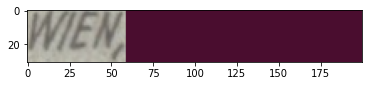

In [105]:
image, text = next(validation_image_gen)
print('text:', text)
_ = plt.imshow(image)

### Training

In [106]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_space.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_space.csv')
]

recognizer.training_model.fit(
    training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=100,
)

Epoch 1/100
452/452 [==============================] - 76s 113ms/step - loss: 12.1130 - val_loss: 8.3067
Epoch 2/100
452/452 [==============================] - 49s 108ms/step - loss: 6.6963 - val_loss: 6.9739
Epoch 3/100
452/452 [==============================] - 49s 107ms/step - loss: 5.5288 - val_loss: 6.8795
Epoch 4/100
452/452 [==============================] - 49s 108ms/step - loss: 5.1825 - val_loss: 6.7024
Epoch 5/100
452/452 [==============================] - 48s 107ms/step - loss: 5.1640 - val_loss: 8.2819
Epoch 6/100
452/452 [==============================] - 48s 106ms/step - loss: 6.2404 - val_loss: 9.0725
Epoch 7/100
452/452 [==============================] - 48s 106ms/step - loss: 6.0203 - val_loss: 9.7556
Epoch 8/100
452/452 [==============================] - 48s 106ms/step - loss: 6.0758 - val_loss: 6.4848
Epoch 9/100
452/452 [==============================] - 48s 106ms/step - loss: 4.7878 - val_loss: 6.9820
Epoch 10/100
452/452 [==============================] - 48s 106

Finally, run inference on a test sample.

Predicted: e, Actual: anker


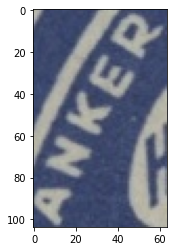

In [107]:
image_filepath, _, actual = train_labels[22]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))

In [108]:
recognizer.model.load_weights('recognizer_space.h5')

Predicted: wien, Actual: wien


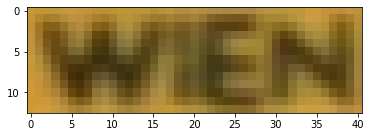

In [112]:
image_filepath, _, actual = train_labels[22]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))